Using RoPE in GPT init: True
number of parameters: 29.94M
Iter     0: train loss = 10.9093, val loss = 10.2242, time/iter = 0.3219s
Iter   100: train loss = 4.2093, val loss = 3.9410, time/iter = 0.0462s
Iter   200: train loss = 3.4748, val loss = 3.5557, time/iter = 0.0523s
Iter   300: train loss = 3.4502, val loss = 3.4067, time/iter = 0.0571s
Iter   400: train loss = 3.0909, val loss = 3.1500, time/iter = 0.0606s
Iter   500: train loss = 3.0896, val loss = 3.3495, time/iter = 0.0635s
Iter   600: train loss = 3.0134, val loss = 2.9051, time/iter = 0.0654s
Iter   700: train loss = 2.7009, val loss = 3.0153, time/iter = 0.0670s
Iter   800: train loss = 2.9038, val loss = 3.0029, time/iter = 0.0681s
Iter   900: train loss = 2.8099, val loss = 2.5873, time/iter = 0.0690s
Iter  1000: train loss = 2.8196, val loss = 2.7192, time/iter = 0.0698s
Iter  1100: train loss = 2.5188, val loss = 2.7621, time/iter = 0.0704s
Iter  1200: train loss = 2.5182, val loss = 2.6649, time/iter = 0.0709s
Iter

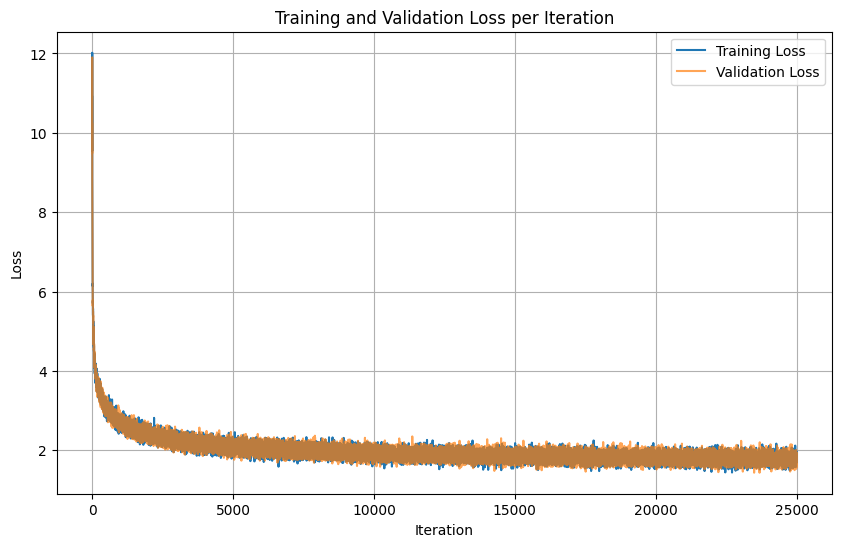

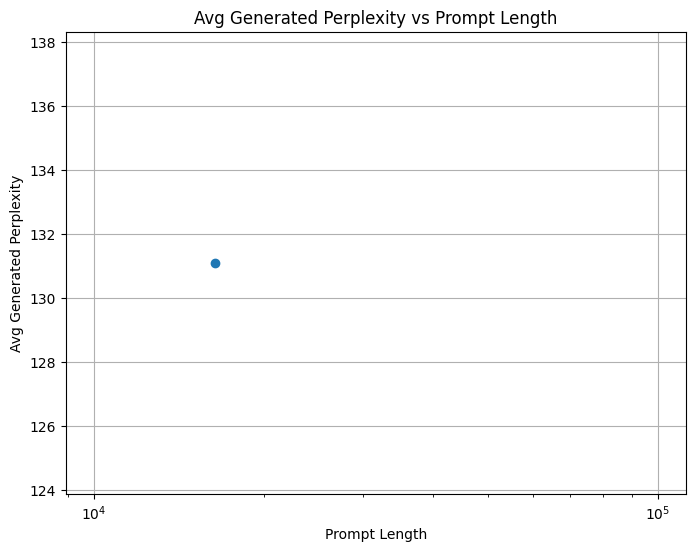

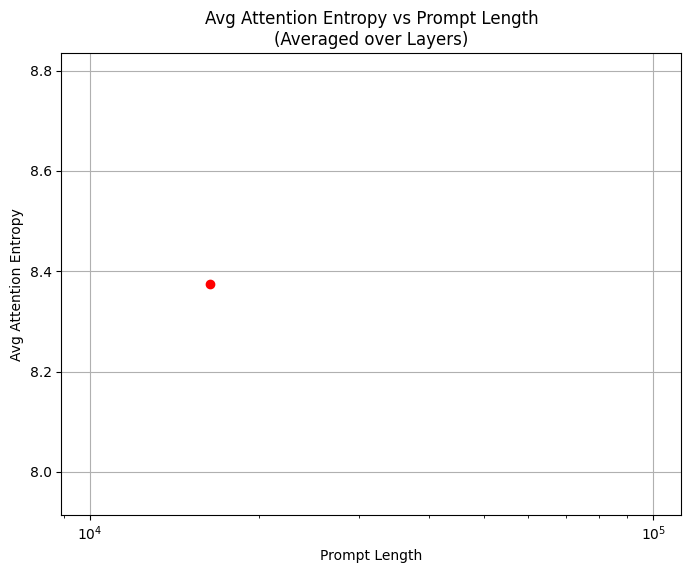

In [1]:
import os
import time
import math
import pickle
import random
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# We use Hugging Face’s transformers only for pretrained weight loading and tokenizer.
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from dataclasses import dataclass

# ----------------------------
# Helper: ALiBi slopes computation
# ----------------------------
def get_alibi_slopes(n_head):
    """Compute ALiBi slopes for each head.
    This implementation follows the approach used in several ALiBi implementations.
    """
    def get_slopes_power_of_2(n):
        start = 2 ** (-2 ** -(math.log2(n) - 3))
        ratio = start
        return [start * (ratio ** i) for i in range(n)]
    if math.log2(n_head).is_integer():
        slopes = get_slopes_power_of_2(n_head)
    else:
        closest_power_of_2 = 2 ** math.floor(math.log2(n_head))
        slopes = get_slopes_power_of_2(closest_power_of_2)
        extra_slopes = get_slopes_power_of_2(2 * closest_power_of_2)[0::2][: n_head - closest_power_of_2]
        slopes.extend(extra_slopes)
    return torch.tensor(slopes, dtype=torch.float32)

# ----------------------------
# Model Components
# ----------------------------

class LayerNorm(nn.Module):
    """LayerNorm with an optional bias."""
    def __init__(self, ndim, bias: bool):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.use_rope = config.use_rope
        self.rope_base = config.rope_base
        # Existing APE support.
        self.use_ape = getattr(config, 'use_ape', False)
        # New: ALiBi support.
        self.use_alibi = getattr(config, 'use_alibi', False)
        if self.use_alibi and self.use_ape:
            raise ValueError("Cannot use both ALiBi and APE simultaneously.")
        # For APE, learn a parameter beta.
        if self.use_ape:
            self.beta = nn.Parameter(torch.tensor(1.0))
        # Use Flash Attention if available (but disable when APE is enabled).
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if (not self.flash) or self.use_ape:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))
        
    def forward(self, x, return_attn_entropy=False, aggregate_heads=False):
        """
        Args:
            x: Input tensor [B, T, C]
            return_attn_entropy (bool): If True, return attention entropy.
            aggregate_heads (bool): If True, average entropy across heads.
        Returns:
            y: Output tensor [B, T, C] or (y, entropy)
        """
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        head_dim = C // self.n_head
        
        # Reshape to [B, n_head, T, head_dim]
        q = q.view(B, T, self.n_head, head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, head_dim).transpose(1, 2)
        
        # Optionally, apply RoPE if enabled.
        if self.use_rope:
            hs = head_dim
            d = hs // 2
            if self.use_ape:
                theta = 1.0 / (self.rope_base ** (2 * torch.arange(0, d, dtype=x.dtype, device=x.device) / hs))
            else:
                theta = 1.0 / (self.rope_base ** (2 * torch.arange(0, d, dtype=x.dtype, device=x.device) / hs))
            t_pos = torch.arange(T, device=x.device, dtype=x.dtype)
            freqs = torch.outer(t_pos, theta)
            freqs_cos = torch.cos(freqs).unsqueeze(0).unsqueeze(0)
            freqs_sin = torch.sin(freqs).unsqueeze(0).unsqueeze(0)
            def apply_rope(tensor, cos, sin):
                tensor = tensor.reshape(*tensor.shape[:-1], -1, 2)
                x0 = tensor[..., 0]
                x1 = tensor[..., 1]
                x0_rot = x0 * cos - x1 * sin
                x1_rot = x0 * sin + x1 * cos
                return torch.stack([x0_rot, x1_rot], dim=-1).flatten(start_dim=-2)
            q = apply_rope(q, freqs_cos, freqs_sin)
            k = apply_rope(k, freqs_cos, freqs_sin)
        
        # Compute scaled dot-product attention scores.
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(head_dim))
        
        # --- Apply positional biases ---
        if self.use_alibi:
            slopes = get_alibi_slopes(self.n_head).to(x.device)  # shape: (n_head,)
            rel_positions = torch.arange(T, device=x.device).unsqueeze(0) - torch.arange(T, device=x.device).unsqueeze(1)
            alibi_bias = slopes.view(1, self.n_head, 1, 1) * rel_positions.view(1, 1, T, T)
            att = att - alibi_bias
        elif self.use_ape:
            pos_ids = torch.arange(T, device=x.device)
            rel_dist = pos_ids.unsqueeze(0) - pos_ids.unsqueeze(1)
            abs_rel = rel_dist.abs().float()
            temp_matrix = 1.0 / (1.0 + abs_rel)
            bias_matrix = - self.beta * torch.log(1.0 + abs_rel)
            temp_matrix = temp_matrix.unsqueeze(0).unsqueeze(0)
            bias_matrix = bias_matrix.unsqueeze(0).unsqueeze(0)
            att = temp_matrix * att + bias_matrix
        
        p_att = F.softmax(att, dim=-1)
        entropy = -(p_att * torch.log(p_att + 1e-9)).sum(dim=-1)  # [B, n_head, T, T]
        
        if self.flash and not self.use_ape:
            y = torch.nn.functional.scaled_dot_product_attention(
                q, k, v,
                attn_mask=None,
                dropout_p=self.dropout if self.training else 0,
                is_causal=True
            )
        else:
            if T > self.bias.size(-1):
                bias = torch.tril(torch.ones(T, T, device=x.device)).view(1, 1, T, T)
            else:
                bias = self.bias[:, :, :T, :T]
            att = att.masked_fill(bias == 0, float('-inf'))
            p_att = F.softmax(att, dim=-1)
            entropy = -(p_att * torch.log(p_att + 1e-9)).sum(dim=-1)
            att = self.attn_dropout(p_att)
            y = att @ v  # [B, n_head, T, head_dim]
        
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        
        if return_attn_entropy:
            if aggregate_heads:
                entropy = entropy.mean(dim=1)  # [B, T, T]
            return y, entropy
        else:
            return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc   = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu   = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)
    def forward(self, x, return_attn_entropy=False, aggregate_heads=False):
        if return_attn_entropy:
            attn_output, entropy = self.attn(self.ln_1(x), return_attn_entropy=True, aggregate_heads=aggregate_heads)
            x = x + attn_output
            x = x + self.mlp(self.ln_2(x))
            return x, entropy
        else:
            attn_output = self.attn(self.ln_1(x), return_attn_entropy=False)
            x = x + attn_output
            x = x + self.mlp(self.ln_2(x))
            return x

@dataclass
class GPTConfig:
    block_size: int = 128
    vocab_size: int = 50304  # For GPT-2
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 384
    dropout: float = 0.0
    bias: bool = True
    use_rope: bool = True
    rope_base: float = 10000.0
    use_ape: bool = False
    lambda_temp: float = 0.1
    use_alibi: bool = False

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None and config.block_size is not None
        self.config = config
        # If using ALiBi, disable RoPE.
        self.use_rope = config.use_rope and not config.use_alibi
        print(f"Using RoPE in GPT init: {self.use_rope}")
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = None if self.use_rope else nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))
    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding and (not self.use_rope) and (self.transformer.wpe is not None):
            n_params -= self.transformer.wpe.weight.numel()
        return n_params
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    def forward(self, idx, targets=None, return_attn_entropy=False, aggregate_heads=False):
        device = idx.device
        b, t = idx.size()
        pos = torch.arange(0, t, dtype=torch.long, device=device)
        tok_emb = self.transformer.wte(idx)
        if self.use_rope or self.config.use_alibi:
            x = self.transformer.drop(tok_emb)
        else:
            pos_emb = self.transformer.wpe(pos) if self.transformer.wpe is not None else 0
            x = self.transformer.drop(tok_emb + pos_emb)
        attn_entropies = []
        for block in self.transformer.h:
            if return_attn_entropy:
                x, entropy = block(x, return_attn_entropy=True, aggregate_heads=aggregate_heads)
                attn_entropies.append(entropy)
            else:
                x = block(x)
        x = self.transformer.ln_f(x)
        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None
        if return_attn_entropy:
            return logits, loss, attn_entropies
        else:
            return logits, loss
    @torch.no_grad()
    def generate_and_compute_perplexity(self, prompt, ground_truth, temperature=1.0, return_attn_entropy=False, aggregate_heads=False):
        if return_attn_entropy:
            _, _, attn_entropies = self(prompt, return_attn_entropy=True, aggregate_heads=aggregate_heads)
            per_layer_avgs = [entropy.mean().item() for entropy in attn_entropies]
            avg_entropy = np.mean(per_layer_avgs)
        else:
            avg_entropy = None
        total_loss = 0.0
        total_tokens = 0
        prompt_length = prompt.size(1)
        num_target_tokens = ground_truth.size(1) - prompt_length
        idx = prompt.clone()
        for i in range(num_target_tokens):
            logits, _ = self(idx)
            logits = logits[:, -1, :] / temperature
            target = ground_truth[:, prompt_length + i]
            loss = F.cross_entropy(logits, target, reduction='sum')
            total_loss += loss.item()
            total_tokens += target.numel()
            target_token = target.unsqueeze(1)
            idx = torch.cat((idx, target_token), dim=1)
        avg_neg_log_likelihood = total_loss / total_tokens if total_tokens > 0 else float('inf')
        perplexity = math.exp(avg_neg_log_likelihood)
        return idx, perplexity, avg_entropy
    @torch.no_grad()
    def generate_until_end(self, idx, temperature=1.0, top_k=None, max_new_tokens=1000):
        for i in range(max_new_tokens):
            idx_cond = idx
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
            if idx_next.item() == 50256:
                break
        return idx

# ----------------------------
# Utility Functions for Training & Evaluation
# ----------------------------

# Data Loader Functions
train_data_path = "/data2/guest/train_tinystories.bin"
val_data_path   = "/data2/guest/val_tinystories.bin"
def get_batch(split):
    data_path = train_data_path if split == 'train' else val_data_path
    data = np.memmap(data_path, dtype=np.uint16, mode='r')
    total_tokens = len(data)
    max_ix = max(1, total_tokens - gptconf.block_size)
    ix = torch.randint(0, max_ix, (batch_size,))
    X = torch.stack([torch.from_numpy(data[i:i+gptconf.block_size].astype(np.int64)) for i in ix])
    Y = torch.stack([torch.from_numpy(data[i+1:i+1+gptconf.block_size].astype(np.int64)) for i in ix])
    return X.to(device), Y.to(device)

def evaluate_prompt_perplexity(model, token_file, prompt_length, num_trials, generation_params, device):
    tokens = np.fromfile(token_file, dtype=np.uint16)
    total_tokens = len(tokens)
    perplexities = []
    entropy_trials = []
    max_new_tokens = generation_params.get("max_new_tokens", 50)
    total_length = prompt_length + max_new_tokens
    for trial in range(num_trials):
        start_idx = random.randint(0, total_tokens - total_length)
        sequence_tokens = tokens[start_idx : start_idx + total_length]
        prompt_tokens = sequence_tokens[:prompt_length]
        ground_truth_tokens = sequence_tokens
        prompt_tensor = torch.tensor(prompt_tokens, dtype=torch.long).unsqueeze(0).to(device)
        ground_truth_tensor = torch.tensor(ground_truth_tokens, dtype=torch.long).unsqueeze(0).to(device)
        _, ppl, trial_entropy = model.generate_and_compute_perplexity(
            prompt_tensor, ground_truth_tensor,
            temperature=generation_params.get("temperature", 1.0),
            return_attn_entropy=True, aggregate_heads=True
        )
        perplexities.append(ppl)
        entropy_trials.append(trial_entropy)
        print(f"Trial {trial+1}/{num_trials} for prompt length {prompt_length}: Perplexity = {ppl:.2f}, Avg Entropy = {trial_entropy:.4f}")
    avg_ppl = np.mean(perplexities)
    avg_entropy = np.mean(entropy_trials)
    print(f"Prompt Length {prompt_length} - Avg Perplexity: {avg_ppl:.2f}, Avg Attention Entropy: {avg_entropy:.4f}\n")
    return avg_ppl, avg_entropy

# ----------------------------
# Training Loop
# ----------------------------
# Training hyperparameters
batch_size = 12
max_iters = 25001
save_interval = 5000
learning_rate = 6e-4
weight_decay = 1e-1
grad_clip = 1.0
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1337)

# Model configuration: adjust these flags as needed.
model_args = dict(
    n_layer=6,
    n_head=6,
    n_embd=384,
    block_size=256,  # You can change this as needed.
    bias=False,
    use_rope=True,
    use_ape=False,    # Set to True if you want APE.
    use_alibi=False, # Set to True to use ALiBi.
    rope_base=10000.0,
    vocab_size=50304,
    dropout=0.0
)
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
iter_num = 0
start_time = time.time()
training_losses = []
validation_losses = []
save_iters = []

# Build a flag string for naming: e.g. "rope_ape" or "alibi" etc.
flag_parts = []
if gptconf.use_rope:
    flag_parts.append("rope")
if gptconf.use_ape:
    flag_parts.append("ape")
if gptconf.use_alibi:
    flag_parts.append("alibi")
flag_str = "_".join(flag_parts) if flag_parts else "none"
weight_dir = f"weights_{flag_str}_{gptconf.block_size}"
os.makedirs(weight_dir, exist_ok=True)

while iter_num < max_iters:
    X_train, Y_train = get_batch('train')
    optimizer.zero_grad()
    logits, loss_train = model(X_train, Y_train)
    loss_train.backward()
    if grad_clip > 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    training_losses.append(loss_train.item())
    
    model.eval()
    X_val, Y_val = get_batch('val')
    with torch.no_grad():
        logits_val, loss_val = model(X_val, Y_val)
    validation_losses.append(loss_val.item())
    model.train()
    
    if iter_num % 100 == 0:
        elapsed = time.time() - start_time
        print(f"Iter {iter_num:5d}: train loss = {loss_train.item():.4f}, val loss = {loss_val.item():.4f}, time/iter = {elapsed/(iter_num+1):.4f}s")
    
    if iter_num > 0 and iter_num % save_interval == 0:
        save_iters.append(iter_num)
        ckpt = {
            'iter_num': iter_num,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_losses': training_losses,
            'validation_losses': validation_losses,
            'save_iters': save_iters,
        }
        ckpt_path = os.path.join(weight_dir, f"ckpt_{iter_num}.pt")
        torch.save(ckpt, ckpt_path)
        print(f"Checkpoint saved to {ckpt_path}")
    
    iter_num += 1

print("Training complete.")

plt.figure(figsize=(10, 6))
plt.plot(range(len(training_losses)), training_losses, label="Training Loss")
plt.plot(range(len(validation_losses)), validation_losses, label="Validation Loss", alpha=0.7)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Iteration")
plt.legend()
plt.grid(True)
# plt.show()

# ----------------------------
# Perplexity & Entropy Evaluation
# ----------------------------

# gptconf = GPTConfig(**model_args)
# model = GPT(gptconf).to(device)
# Load the model weights from the last checkpoint.
# checkpoint_path = "/home/arnavbhatt/arnav/project/Nitin_experiment/Streamlined/COLM2025/Last_week/Gold_Standard/weights_rope_64/ckpt_25000.pt"
# checkpoint = torch.load(checkpoint_path, map_location = device)
# model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

token_file = val_data_path  # Use validation data for evaluation.
prompt_lengths = [16384]
num_trials = 2
generation_params = {"temperature": 1.0, "max_new_tokens": 50}

avg_perplexities = []
avg_entropies = []

for pl in prompt_lengths:
    print(f"Evaluating for prompt length: {pl}")
    avg_ppl, avg_entropy = evaluate_prompt_perplexity(model, token_file, pl, num_trials, generation_params, device)
    avg_perplexities.append(avg_ppl)
    avg_entropies.append(avg_entropy)

results = {
    "prompt_lengths": prompt_lengths,
    "avg_perplexities": avg_perplexities,
    "avg_entropies": avg_entropies
}
results_filename = f"results_{flag_str}_{gptconf.block_size}.json"
with open(results_filename, "w") as f:
    json.dump(results, f)
print(f"Results saved to {results_filename}")

plt.figure(figsize=(8, 6))
plt.plot(prompt_lengths, avg_perplexities, marker='o')
plt.xlabel("Prompt Length")
plt.ylabel("Avg Generated Perplexity")
plt.title("Avg Generated Perplexity vs Prompt Length")
plt.grid(True)
plt.xscale('log')
plt.savefig(f"avg_generated_perplexity_{flag_str}_{gptconf.block_size}.png")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(prompt_lengths, avg_entropies, marker='o', color='red')
plt.xlabel("Prompt Length")
plt.ylabel("Avg Attention Entropy")
plt.title("Avg Attention Entropy vs Prompt Length\n(Averaged over Layers)")
plt.grid(True)
plt.xscale('log')
plt.savefig(f"avg_attention_entropy_{flag_str}_{gptconf.block_size}.png")
plt.show()
